<a href="https://colab.research.google.com/github/aryan2107-cloud/100-Day-ML-Challenge-/blob/main/Day20_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
print('Setup complete')

Setup complete


## Why Ensemble?

**Problem with single decision tree:**
- High variance (unstable)
- Small data change → completely different tree

**Solution: Ensemble (combine many trees)**
- Each tree sees different data (bagging)
- Each tree sees different features (random subspace)
- Average predictions → reduces variance

In [2]:
from sklearn.datasets import fetch_covtype

covtype = fetch_covtype()
x_full, y_full = covtype.data, covtype.target

print(f"Full dataset {x_full.shape[0]:,} samples, {x_full.shape[1]} features")
print(f"Classes: {np.unique(y_full)} (7 forest cover types)")

Full dataset 581,012 samples, 54 features
Classes: [1 2 3 4 5 6 7] (7 forest cover types)


In [3]:
np.random.seed(42)
sample_idx = np.random.choice(len(x_full), size=20000, replace=False)
x = x_full[sample_idx]
y = y_full[sample_idx]

print(f"Sampled: {len(x):,} samples")

Sampled: 20,000 samples


In [4]:
feature_names = [
    'Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
    'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
    'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points'
] + [f'Wilderness_Area_{i}' for i in range(1, 5)] + [f'Soil_Type_{i}' for i in range(1, 41)]

class_names = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']

print(f"Features: {len(feature_names)}")
print(f"Classes: {class_names}")


Features: 54
Classes: ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']


<function matplotlib.pyplot.show(close=None, block=None)>

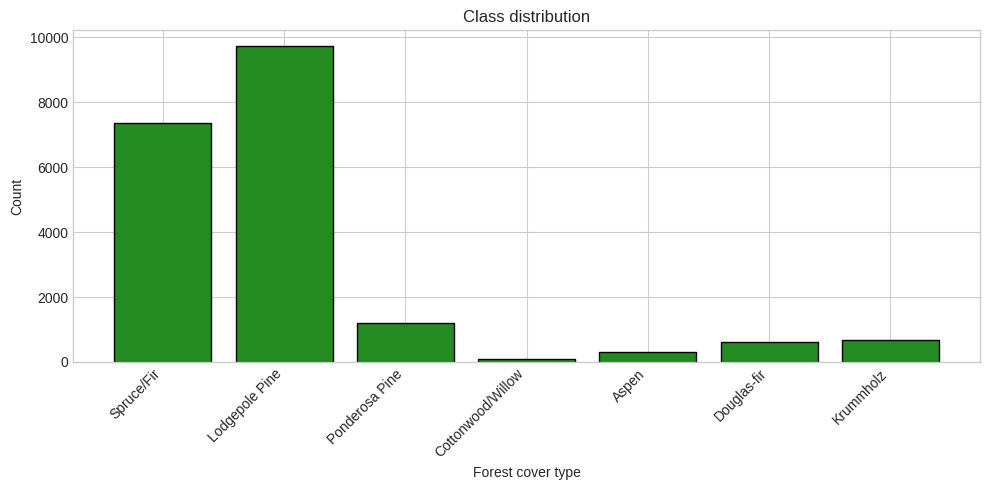

In [5]:
#Class distribution
unique, counts = np.unique(y, return_counts=True)

plt.figure(figsize=(10, 5))
plt.bar(class_names, counts, color='forestgreen', edgecolor='black')
plt.xlabel('Forest cover type')
plt.ylabel('Count')
plt.title('Class distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train: {len(x_train):,} samples")
print(f"Test: {len(x_test):,} samples")

Train: 16,000 samples
Test: 4,000 samples


Single Tree Baseline

In [7]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(x_train, y_train)

print(f"Train accuracy: {tree.score(x_train, y_train):.2f}")
print(f"Test accuracy: {tree.score(x_test, y_test):.2f}")
print(f"Depth: {tree.get_depth()}")

Train accuracy: 1.00
Test accuracy: 0.76
Depth: 34


In [8]:
#Tree Variance: different random seeds -> different trees
tree_scores = []
for seed in range(20):
  x_tr, _, y_tr, _ = train_test_split(x_train, y_train, test_size=0.1, random_state=seed)
  t = DecisionTreeClassifier(random_state=42)
  t.fit(x_tr, y_tr)
  tree_scores.append(t.score(x_test, y_test))

print(f"Mean: {np.mean(tree_scores):.2f}")
print(f"Std: {np.std(tree_scores):.2f}")
print(f"Range: {np.min(tree_scores):.2f} - {np.max(tree_scores):.2f}")


Mean: 0.75
Std: 0.01
Range: 0.74 - 0.76


Bagging

In [10]:
#Bagging - Training trees on bootstrap samples
bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
bagging.fit(x_train, y_train)

print(f" Train Accuracy: {bagging.score(x_train, y_train):.4f}")
print(f" Test Accuracy: {bagging.score(x_test, y_test):.4f}")

 Train Accuracy: 0.9999
 Test Accuracy: 0.8390


Random forest

In [11]:
#It is bagging + Random feature subsets
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(x_train, y_train)

print(f" Train Accuracy: {rf.score(x_train, y_train):.4f}")
print(f" Test Accuracy: {rf.score(x_test, y_test):.4f}")

 Train Accuracy: 0.9999
 Test Accuracy: 0.8337


In [14]:
#Comparing all three
print("Model Comparison")
print("----------------")
print(f"{'Single Tree':<20} {tree.score(x_train, y_train):<12.4f} {tree.score(x_test, y_test):<12.4f}")
print(f"{'Bagging (50)':<20} {bagging.score(x_train, y_train):<12.4f} {bagging.score(x_test, y_test):<12.4f}")
print(f"{'Random Forest (100)':<20} {rf.score(x_train, y_train):<12.4f} {rf.score(x_test, y_test):<12.4f}")

Model Comparison
----------------
Single Tree          1.0000       0.7558      
Bagging (50)         0.9999       0.8390      
Random Forest (100)  0.9999       0.8337      


Out-of-bag Score (OOB) Score

In [15]:
# The remaining 37% of the data can be used for validation
rf_oob = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42, n_jobs=-1)

rf_oob.fit(x_train, y_train)

print(f"OOB SCORE")
print(f"Accuracy: {rf_oob.score(x_test, y_test):.4f}")
print(f"OOB Score: {rf_oob.oob_score_:.4f}")

OOB SCORE
Accuracy: 0.8337
OOB Score: 0.8288


Feature Importance

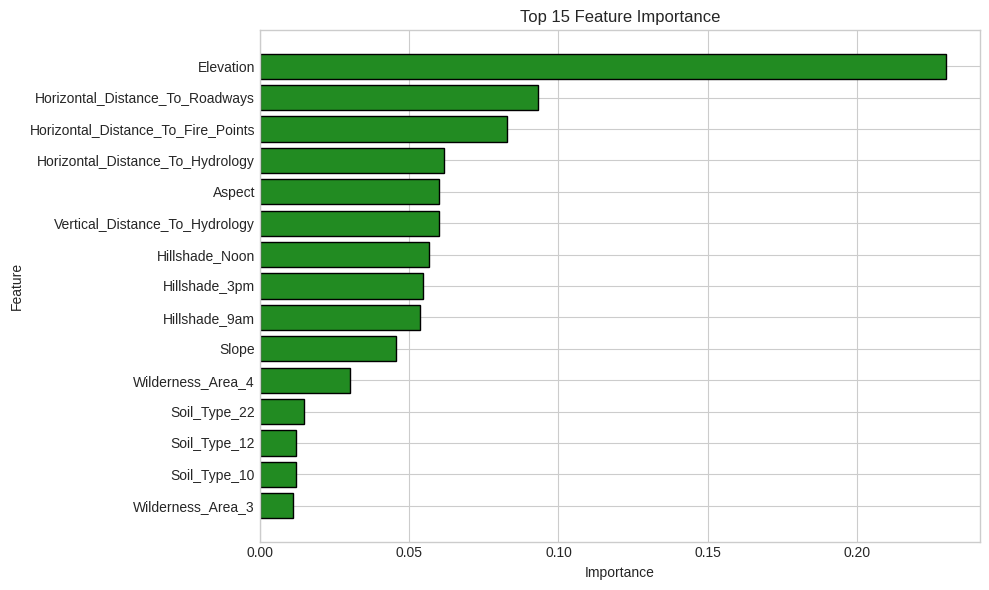

                              Feature  Importance
0                           Elevation    0.229707
5     Horizontal_Distance_To_Roadways    0.093128
9  Horizontal_Distance_To_Fire_Points    0.082876
3    Horizontal_Distance_To_Hydrology    0.061687
1                              Aspect    0.060060
4      Vertical_Distance_To_Hydrology    0.059877
7                      Hillshade_Noon    0.056762
8                       Hillshade_3pm    0.054719
6                       Hillshade_9am    0.053656
2                               Slope    0.045727


In [17]:
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

# Top 15
top_n = 15
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:top_n][::-1],
         importance_df['Importance'][:top_n][::-1],
         color='forestgreen', edgecolor='black')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'Top {top_n} Feature Importance')
plt.tight_layout()
plt.show()

print(importance_df.head(10))

In [22]:
#Comparing with single tree importance
tree_importance = pd.DataFrame({
    'Feature': feature_names,
    'Tree': tree.feature_importances_,
    'Forest': rf.feature_importances_
}).sort_values('Forest', ascending=False).head(10)

print(tree_importance.round(4).to_string(index=False))


                           Feature   Tree  Forest
                         Elevation 0.3418  0.2297
   Horizontal_Distance_To_Roadways 0.1146  0.0931
Horizontal_Distance_To_Fire_Points 0.1062  0.0829
  Horizontal_Distance_To_Hydrology 0.0711  0.0617
                            Aspect 0.0460  0.0601
    Vertical_Distance_To_Hydrology 0.0547  0.0599
                    Hillshade_Noon 0.0479  0.0568
                     Hillshade_3pm 0.0326  0.0547
                     Hillshade_9am 0.0398  0.0537
                             Slope 0.0292  0.0457


Hyperparameter Tuning

In [27]:
"""
Key hyperparameters:
- n_estimators: Number of trees in the forest
- max_depth: Maximum depth of each tree
- min_samples_split: Minimum number of samples required to split an internal node
- min_samples_leaf: Minimum number of samples required to be at a leaf node
- max_features: Maximum number of features to consider when looking for the best split
- bootstrap: Whether to use bootstrap samples when building trees
"""

param_grid = {
    'n_estimators':[50, 100],
    'max_depth': [10, 20, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [1, 2]
}

grid_search  = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid, cv=3, scoring='accuracy', n_jobs=-1
)
grid_search.fit(x_train, y_train)

print(f"best params: {grid_search.best_params_}")
print(f"best CV score: {grid_search.best_score_}")
print(f"Test Score: {grid_search.score(x_test, y_test):4f}")

best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}
best CV score: 0.8152496079561402
Test Score: 0.833750


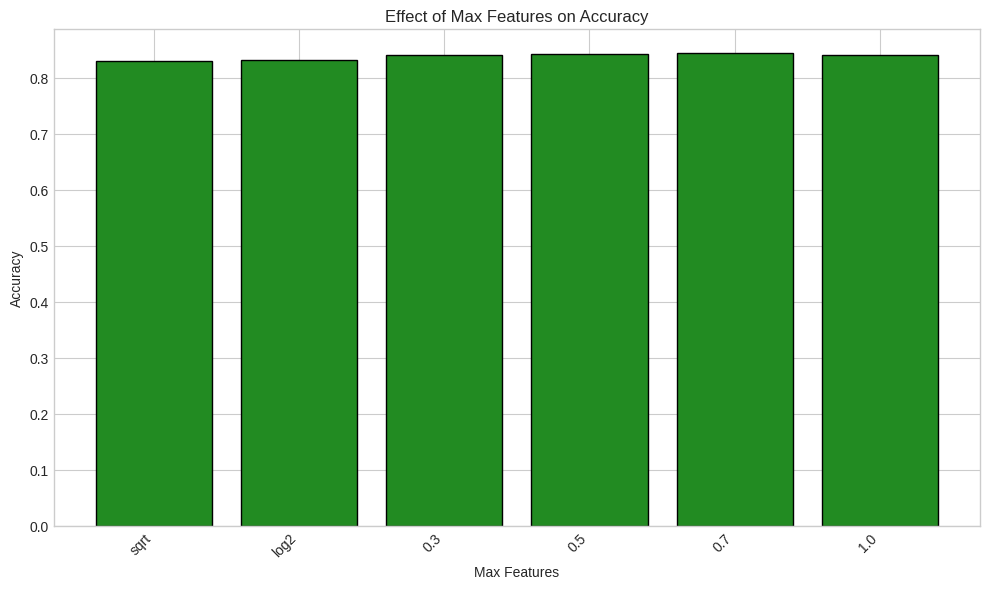

In [33]:
#The effect of max_features
max_features_options = ['sqrt', 'log2', 0.3, 0.5, 0.7, 1.0]
scores = []

for mf in max_features_options:
  rf_mf = RandomForestClassifier(n_estimators=50, max_features=mf,
                                 random_state=42, n_jobs=-1)
  rf_mf.fit(x_train, y_train)
  scores.append(rf_mf.score(x_test, y_test))

plt.figure(figsize=(10, 6))
plt.bar([str(x) for x in max_features_options], scores,
        color='forestgreen', edgecolor='black')
plt.xlabel('Max Features')
plt.ylabel('Accuracy')
plt.title('Effect of Max Features on Accuracy')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [34]:
#Final Evaluation
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(x_test)

print(classification_report(y_test, y_pred, target_names=class_names))

                   precision    recall  f1-score   support

       Spruce/Fir       0.85      0.81      0.83      1473
   Lodgepole Pine       0.83      0.89      0.86      1945
   Ponderosa Pine       0.78      0.88      0.83       241
Cottonwood/Willow       0.88      0.41      0.56        17
            Aspen       0.76      0.25      0.38        64
      Douglas-fir       0.74      0.51      0.60       125
        Krummholz       0.95      0.80      0.87       135

         accuracy                           0.83      4000
        macro avg       0.83      0.65      0.70      4000
     weighted avg       0.83      0.83      0.83      4000



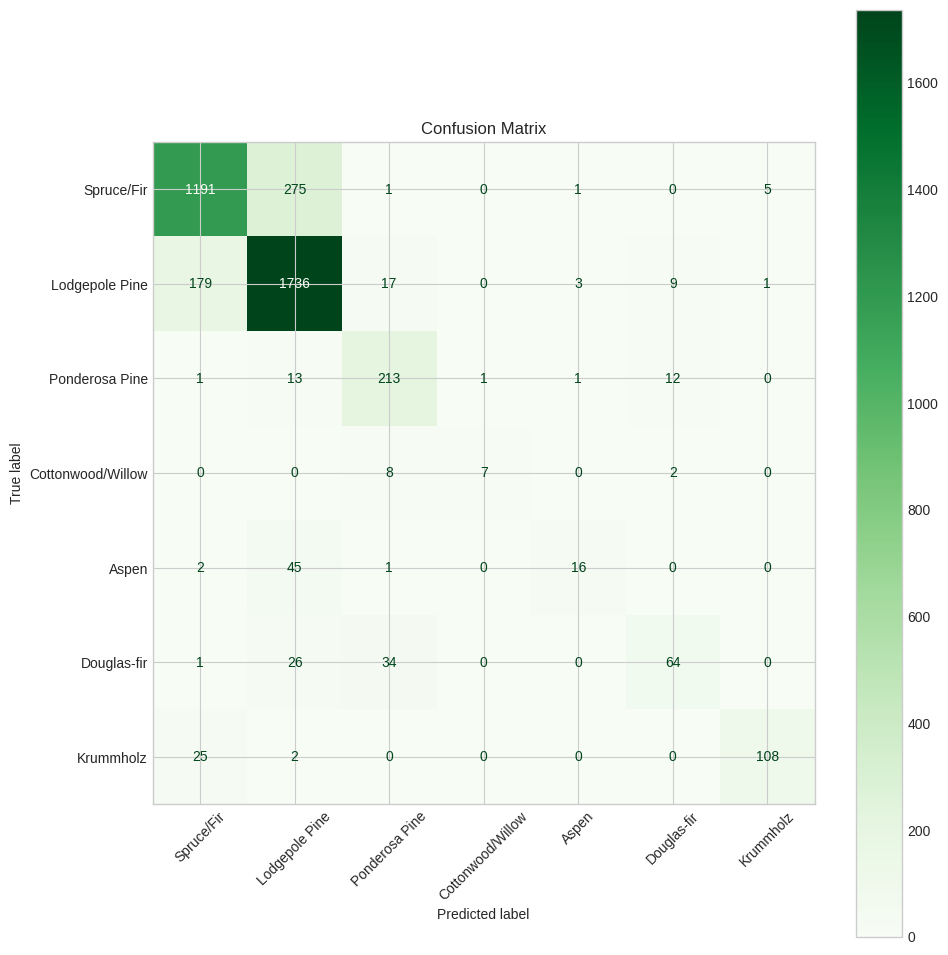

In [38]:
#confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=class_names,
                      cmap='Greens', ax=ax, xticks_rotation=45)
ax.set_title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [40]:
# Final comparison
print("\n" + "="*50)
print("FINAL COMPARISON")
print("="*50)
print(f"{'Model':<25} {'Test Accuracy':<15}")
print("-"*40)
print(f"{'Single Decision Tree':<25} {tree.score(x_test, y_test):<15.4f}")
print(f"{'Bagging (50 trees)':<25} {bagging.score(x_test, y_test):<15.4f}")
print(f"{'Random Forest (100)':<25} {rf.score(x_test, y_test):<15.4f}")
print(f"{'Random Forest (tuned)':<25} {best_rf.score(x_test, y_test):<15.4f}")


FINAL COMPARISON
Model                     Test Accuracy  
----------------------------------------
Single Decision Tree      0.7558         
Bagging (50 trees)        0.8390         
Random Forest (100)       0.8337         
Random Forest (tuned)     0.8337         



## Summary

### Random Forest = Bagging + Random Features

| Component | Purpose |
|-----------|--------|
| Bootstrap samples | Reduces variance |
| Random feature subsets | Decorrelates trees |
| Averaging predictions | Smooths out noise |

### Key Hyperparameters

| Parameter | Default | Notes |
|-----------|---------|-------|
| n_estimators | 100 | More = better (diminishing returns) |
| max_features | 'sqrt' | Lower = more diversity |
| max_depth | None | Limit to reduce overfitting |
| min_samples_leaf | 1 | Increase for smoother predictions |

### Pros
- Rarely overfits (with enough trees)
- Handles high dimensions well
- Built-in feature importance
- OOB score (free validation)

### Cons
- Less interpretable than single tree
- Slower than single tree
- Memory intensive
